In [ ]:
import numpy as np
# from scipy import pi, exp

def psi0(x, y, z, x0, y0, z0, sigma=0.5, k=15*np.pi):

    """
    Proposed wave function for the initial time t=0.
    Using NumPy arrays for calculations.
    """
    Norm1D = 1/((2*np.pi*sigma*sigma)**(0.25))
    Norm3D = Norm1D*Norm1D*Norm1D
    return Norm3D*np.exp(-1/4*((y-y0)**2 + (z-z0)**2 + (x-x0)**2)/sigma**2)*np.exp(1j*k*(x-x0))
    #return np.exp(-1/2*((y-y0)**2 + (z-z0)**2 + (x-x0)**2)/sigma**2)*np.exp(1j*k*(x-x0))# original Shounak

# def doubleSlit_interaction(psi, i0, i1, j0, j1, j2, j3, k0, k1):

#     """
#     Double slit interaction using NumPy arrays for calculations.
#     """

#     psi = cp.asarray(psi)  # Ensure psi is a NumPy array

#     psi[i0:i1, :j0, :] = 0
#     psi[i0:i1, j0:j1, :k0] = 0
#     psi[i0:i1, j0:j1, k1:] = 0
#     psi[i0:i1, j1:j2, :] = 0
#     psi[i0:i1, j2:j3, :k0] = 0
#     psi[i0:i1, j2:j3, k1:] = 0
#     psi[i0:i1, j3:, :] = 0

#     return psi


In [ ]:
import numpy as np
L = 8 # Well of width L. Shafts from 0 to +L.
Dy = 0.4 # Spatial step size. # Dy= Dz=Dx
Dt = Dy**2/4 # Temporal step size.
Nx = int(L/Dy) + 1 # Number of points on the x axis.
Ny = int(L/Dy) + 1 # Number of points on the y axis.
Nz = int(L/Dy) + 1 # Number of points on the z axis.

Nt = 40 # Number of time steps.
rx = -Dt/(2j*Dy**2) # Constant to simplify expressions.
ry = -Dt/(2j*Dy**2) # Constant to simplify expressions.
rz = -Dt/(2j*Dy**2) # Constant to simplify expressions.
a = 1 + 2*rx + 2*ry
b = 1 - 2*rx - 2*ry
# Initial position of the center of the Gaussian wave function.
x0 = L/5
y0 = L/2
z0 = L/2
# Parameters of the double slit.
w = 0.5 # Width of the walls of the double slit.
b = 8.0 # Breadth of the double slit.
s = 1.8 # Separation between the edges of the slits.
a = 0.5 # Aperture of the slits.

# Indices that parameterize the double slit in the space of points.
# Horizontal axis.
i0 = int(1/(2*Dy)*(L-w)) # Left edge.
i1 = int(1/(2*Dy)*(L+w)) # Right edge.
# Eje vertical.
j3 = int(1/(2*Dy)*(L+s) + a/Dy) # Lower edge of the lower slit.
j2 = int(1/(2*Dy)*(L+s))        # Upper edge of the lower slit.
j1 = int(1/(2*Dy)*(L-s))        # Lower edge of the upper slit.
j0 = int(1/(2*Dy)*(L-s) - a/Dy) # Upper edge of the upper slit.

k0 = int(1/(2*Dy)*(L-b))
k1 = int(1/(2*Dy)*(L+b))

print(i0,i1,j0,j1,j2,j3,k0,k1)
v = np.zeros((Nx,Ny,Nz), complex) # Potential.
Ni = (Nx-2)*(Ny-2)*(Nz-2)  # Number of unknown factors v[i,j], i = 1,...,Nx-2, j = 1,...,Ny-2
print(Nx,Ny,Nz,Ni)


9 10 6 7 12 13 0 20
21 21 21 6859


In [1]:
import cupy as cp
import cupyx.scipy.sparse as sparse

# Assuming `Nx`, `Ny`, and `Nz` are already Cupy arrays if not convert them
# Nx = cp.array(Nx)
# Ny = cp.array(Ny)
# Nz = cp.array(Nz)
A = 1 + 2*rx + 2*ry + 2*rz#+ 1j*Dt/2*v[k,k,k]
B = 1 - 2*rx - 2*ry -2*rz#+ 1j*Dt/2*v[k,k,k]

diag = cp.ones([Ni])
diags1 = cp.array([-rx*diag, -ry*diag, -rz*diag, A*diag, -rz*diag, -ry*diag, -rx*diag])
diags2 = cp.array([rx*diag, ry*diag, rz*diag, B*diag, rz*diag, ry*diag, rx*diag])

# Construct sparse matrices
A = sparse.spdiags(diags1, cp.array([-(Nx-2)*(Nx-2), -(Nx-2), -1, 0, 1, (Nx-2), (Nx-2)*(Nx-2)]), Ni, Ni)
M = sparse.spdiags(diags2, cp.array([-(Nx-2)*(Nx-2), -(Nx-2), -1, 0, 1, (Nx-2), (Nx-2)*(Nx-2)]), Ni, Ni)

print(A.shape)
print(M.shape)


NameError: name 'rx' is not defined

In [ ]:
print(type(A))

<class 'cupyx.scipy.sparse._dia.dia_matrix'>


In [ ]:
# import torch
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

A = A.tocsr()
M = M.tocsr()
# M = torch.sparse_coo_tensor(indices=torch.tensor([M.row, M.col]), values=torch.tensor(M.data), size=M.shape).to(device)
# A = torch.sparse_coo_tensor(indices=torch.tensor([A.row, A.col]), values=torch.tensor(A.data), size=A.shape).to(device)

In [ ]:
type(A)

cupyx.scipy.sparse._csr.csr_matrix

In [ ]:
# import cupy as cp
from cupyx.scipy.sparse.linalg import spsolve
from cupy.sparse import csr_matrix

# Assuming A and M are scipy.sparse._dia.dia_matrix
# A = dia_matrix(...)
# M = dia_matrix(...)

# Crate tensors for x, y, z
x = cp.linspace(0, L, Ny-2)  # Array of spatial points.
y = cp.linspace(0, L, Ny-2)  # Array of spatial points.
z = cp.linspace(0, L, Ny-2)  # Array of spatial points.

# Create 3D meshgrid
X, Y, Z = cp.meshgrid(x, y, z,indexing='ij')

# Initialize psis and psi
psis = []  # To store the wave function at each time step.
psi = psi0(X, Y, Z, x0, y0, z0)  # Initialize the wave function with the Gaussian.
print("psi0",type(psi))
psi[0, :, :], psi[-1, :, :], psi[:, 0, :], psi[:, -1, :], psi[:, :, 0], psi[:, :, -1] = 0, 0, 0, 0, 0, 0  # Set boundaries to zero
# psi = doubleSlit_interaction(psi, i0, i1, j0, j1, j2, j3, k0, k1)
psis.append(psi)  # Store the wave function of this time step

for i in range(1, Nt):
    # print(type(psi))
    psi_vect = psi.reshape(Ni)
    # print(type(M),type(psi_vect),type(psi_vect[0]))
    # print(psi_vect.shape,M.shape,psi_vect[0].shape)
    psi_vect = cp.array(psi_vect)
    print(psi_vect.shape)
    b = M.dot(psi_vect) # Calculate the array of independent terms
    # print("b.shape:", b.shape)  # Print shape of the result
    psi_vect = spsolve(A, b)  # Solve the system for this temporal step
    psi = psi_vect.reshape(Nx-2, Ny-2, Nz-2)  # Reshape the array to the shape of the wave function
    # psi = doubleSlit_interaction(psi, i0, i1, j0, j1, j2, j3, k0, k1)
    psis.append(psi)  # Save the result
    print(i*100/Nt)


# Calculate the modulus of the wave function at each time step
mod_psis = [abs(wavefunc) for wavefunc in psis]


psi0 <class 'cupy.ndarray'>
(6859,)
2.5
(6859,)
5.0
(6859,)
7.5
(6859,)
10.0
(6859,)
12.5
(6859,)
15.0
(6859,)
17.5
(6859,)
20.0
(6859,)
22.5
(6859,)
25.0
(6859,)
27.5
(6859,)
30.0
(6859,)
32.5
(6859,)
35.0
(6859,)
37.5
(6859,)
40.0
(6859,)
42.5
(6859,)
45.0
(6859,)
47.5
(6859,)
50.0
(6859,)
52.5
(6859,)
55.0
(6859,)
57.5
(6859,)
60.0
(6859,)
62.5
(6859,)
65.0
(6859,)
67.5
(6859,)
70.0
(6859,)
72.5
(6859,)
75.0
(6859,)
77.5
(6859,)
80.0
(6859,)
82.5
(6859,)
85.0
(6859,)
87.5
(6859,)
90.0
(6859,)
92.5
(6859,)
95.0
(6859,)
97.5


In [ ]:
# print(A.shape,A[i].shape)
# for i in range(0,Ni):
#     for j in range(0,Ni):
#         print(A[i,j],end=' ')
#     print()

In [ ]:
type(mod_psis)

list

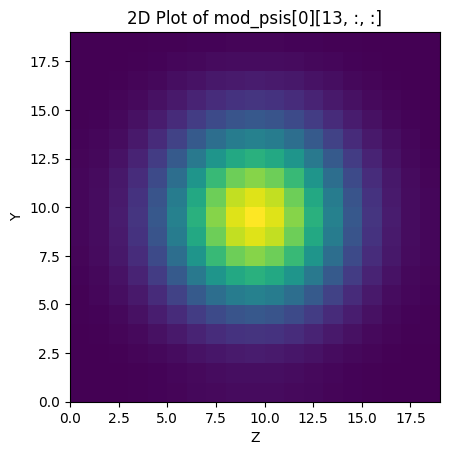

In [ ]:
# Print the values in the specified format
# for it in mod_psis:
#     for j in range(0, it.shape[0]):
#         for k in range(0, it.shape[1]):
#             print(it[13, j, k], end=' ')
#         print()
#     print("done")
import matplotlib.pyplot as plt
# Create a 2D plot
fig, ax = plt.subplots()
ax.imshow(mod_psis[10][16, :, :].get(), cmap='viridis', origin='lower', extent=(0, mod_psis[0].shape[1], 0, mod_psis[0].shape[0]))
ax.set_xlabel('Z')
ax.set_ylabel('Y')
ax.set_title('2D Plot of mod_psis[0][13, :, :]')

plt.show()

In [ ]:
psis_numpy = [arr.get() for arr in psis]

# Save the list of NumPy arrays to a file
np.save('data_array.npy', psis_numpy)

In [ ]:
loaded_array_list = np.load('data_array.npy', allow_pickle=True)

In [ ]:
new_mod_psis = [abs(wavefunc) for wavefunc in loaded_array_list]

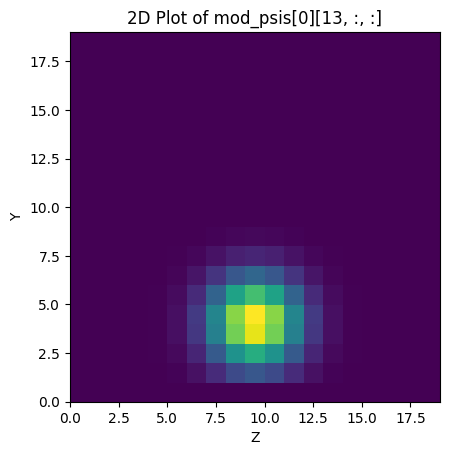

In [ ]:
import matplotlib.pyplot as plt
# Create a 2D plot
fig, ax = plt.subplots()
ax.imshow(new_mod_psis[0][:, 16, :], cmap='viridis', origin='lower', extent=(0, mod_psis[0].shape[1], 0, mod_psis[0].shape[0]))
ax.set_xlabel('Z')
ax.set_ylabel('Y')
ax.set_title('2D Plot of mod_psis[0][13, :, :]')

plt.show()

[[3.6, 4.9, 4.9], [3.6, 4.925000000000001, 4.925000000000001], [3.6, 4.95, 4.95], [3.6, 4.9750000000000005, 4.9750000000000005], [3.6, 5.0, 5.0], [3.6, 5.025, 5.025], [3.6, 5.050000000000001, 5.050000000000001], [3.6, 5.075, 5.075], [3.6, 5.1000000000000005, 5.1000000000000005], [3.6, 5.125, 5.125], [3.6, 5.15, 5.15], [3.6, 5.175000000000001, 5.175000000000001], [3.6, 5.2, 5.2], [3.6, 5.2250000000000005, 5.2250000000000005], [3.6, 5.25, 5.25], [3.6, 5.275, 5.275], [3.6, 5.300000000000001, 5.300000000000001], [3.6, 5.325, 5.325], [3.6, 5.3500000000000005, 5.3500000000000005], [3.6, 5.375, 5.375], [3.6, 2.625, 2.625], [3.6, 2.65, 2.65], [3.6, 2.6750000000000003, 2.6750000000000003], [3.6, 2.7, 2.7], [3.6, 2.725, 2.725], [3.6, 2.75, 2.75], [3.6, 2.775, 2.775], [3.6, 2.8000000000000003, 2.8000000000000003], [3.6, 2.825, 2.825], [3.6, 2.85, 2.85], [3.6, 2.875, 2.875], [3.6, 2.9, 2.9], [3.6, 2.9250000000000003, 2.9250000000000003], [3.6, 2.95, 2.95], [3.6, 2.975, 2.975], [3.6, 3.0, 3.0], [3.

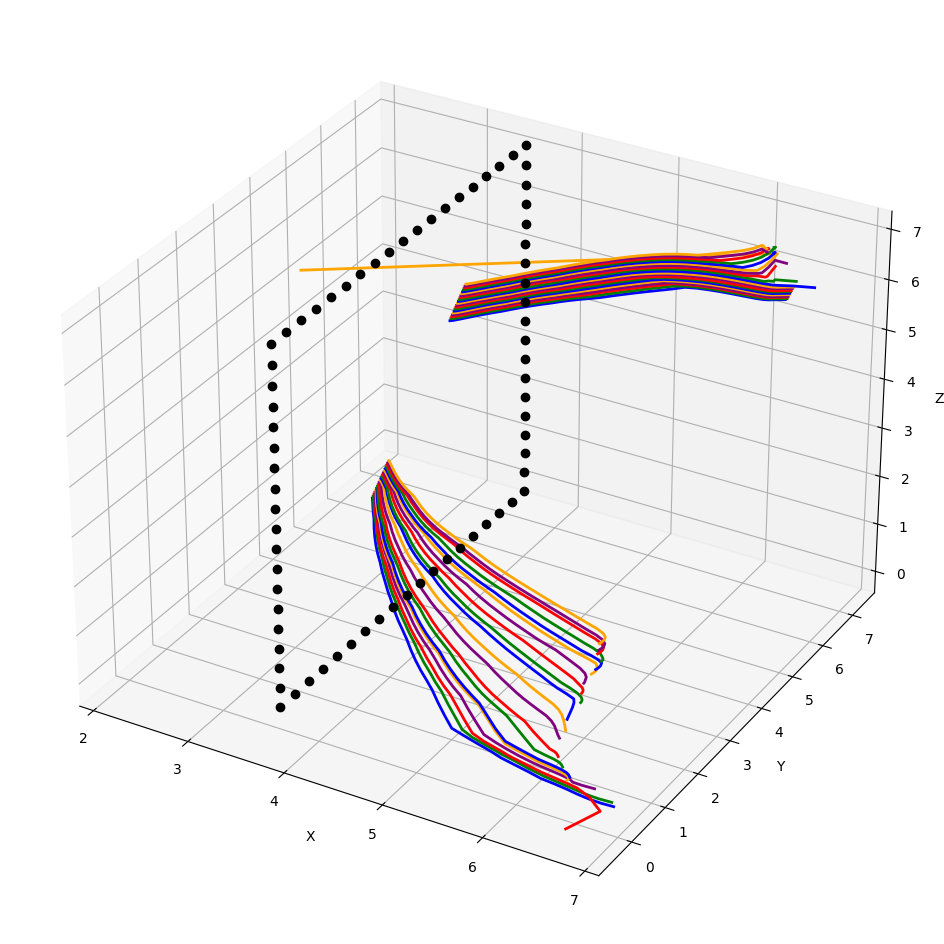

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import cupy

# Initialize particle positions (assuming L is defined)
num_particles = 40 # Replace with the actual number of particles
# particle_position = [[3*L/8, L/4], [3*L/8, 2*L/4], [3*L/8, 3*L/4]]
particle_position = []
e=1e-20
num_per_half = int(num_particles / 2)
half_L = L / 2
half_s = s / 2

# half_L = half_L - .02
# half_s = half_s + .02
# Filling particles between L/2 + s/2 and L/2 + s/2 + a
for i in range(num_per_half):
    y_pos = half_L + half_s + (i * a) / num_per_half
    particle_position.append([i0*Dy, y_pos,y_pos])

# Filling particles between L/2 - s/2 and L/2 - s/2 - a (reverse order for symmetry)
for i in range(num_per_half - 1, -1, -1):
    y_pos = half_L - half_s - (i * a) / num_per_half
    particle_position.append([i0*Dy, y_pos,y_pos])




    # particle_position[i][1] = i*L/(num_particles)
# Assuming psis is defined elsewhere and contains wavefunction values
print(particle_position)
# Dictionaries to store particle positions (generalized)
particle_data = {i: {'x': [], 'y': [], 'z': []} for i in range(num_particles)}
# Simulate particle movement
for wavefunc in psis:
    for l, particle in enumerate(particle_position):
        # print(wavefunc.shape)
        i = int(particle[0] / Dy)
        j = int(particle[1] / Dy)
        k = int(particle[2] / Dy)

        # print("no",i,j)
        if(i<0 or j<0):
            continue

        elif(i<=17 and j<=17 and k<=17):
            Rx = (wavefunc[i + 1, j, k] - wavefunc[i, j, k]) / Dy
            Ry = (wavefunc[i, j + 1, k] - wavefunc[i, j, k]) / Dy
            Rz = (wavefunc[i, j, k + 1] - wavefunc[i, j, k]) / Dy
        else:
            continue

        if(wavefunc[i,j,k]==0):
            continue


            # Calculate force using valid indices


        Rx = Rx / (wavefunc[i, j, k] + e)
        Ry = Ry / (wavefunc[i, j, k] + e)
        Rz = Rz / (wavefunc[i, j, k] + e)
        # print(wavefunc[i,j])
        # if (wavefunc[i,j]==0):
        #     print(0)

        Rx = Dt * Rx.imag
        Ry = Dt * Ry.imag
        Rz = Dt * Rz.imag
        # print(particle[0],particle[1],Ry)
        particle[0] += Rx
        particle[1] += Ry
        particle[2] += Rz

        # Append positions to dictionaries
        particle_data[l]['x'].append(cupy.asnumpy(particle[0]))
        particle_data[l]['y'].append(cupy.asnumpy(particle[1]))
        particle_data[l]['z'].append(cupy.asnumpy(particle[2]))


# Uncomment the following section for plotting particle movement

# Plot particle movement with different colors
colors = ['blue', 'green', 'red', 'purple', 'orange']  # Adjust colors as needed
fig = plt.figure(figsize=(12, 12))  # Set figure size for better visualization
ax = fig.add_subplot(111, projection='3d')


# Loop through particle data and plot trajectories
for i, particle in particle_data.items():
    label = f'Particle {i+1}'  # Adjust label format if needed
    plt.plot(particle['x'], particle['y'], particle['z'], label=label, color=colors[i % len(colors)], linewidth=2)  # Plot in 3D with z-coordinates



for i in range(i0,i1):
  for j in range(psis[0].shape[1]):
    for k in range(psis[0].shape[2]):
      if (psis[0][i, j, k] == 0):
          plt.plot(i * Dy, j * Dy, k * Dy, color='black', marker='o')  # Use marker for better visibility

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')  # Add label for z-axis

# plt.legend()
plt.show()

